 # Lab 2: Classification

### Machine Learning 1, October 2023

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* When practising with this lab you should vectorized your code (and rely on loops as little as possible). Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.
* Ignore the np_conda warning!
* Do not add or delete cells. It can lead to penalties during grading.
* If you use google collab, just copy paste your solution to this notebook before the submission. Sometimes, google colab can break the auto-grading mechanism.

**IMPORTANT: Note that for this code exercise we are using flipped notation (denominator layout) for the gradient and the derivations.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [1]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

You have a friend with one big problem which needs your help: Your friend wants to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers) by using Logistic Regression.

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [3]:
from sklearn.datasets import fetch_openml
import os
import pdb
import numpy as np
# Fetch the data
try:
    mnist = fetch_openml('mnist_784')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())

data, target = mnist.data, mnist.target.astype('int')

data = data.to_numpy()
target = target.to_numpy()
# Shuffle


indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)

data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

In [4]:
x_train.shape

(50000, 784)

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

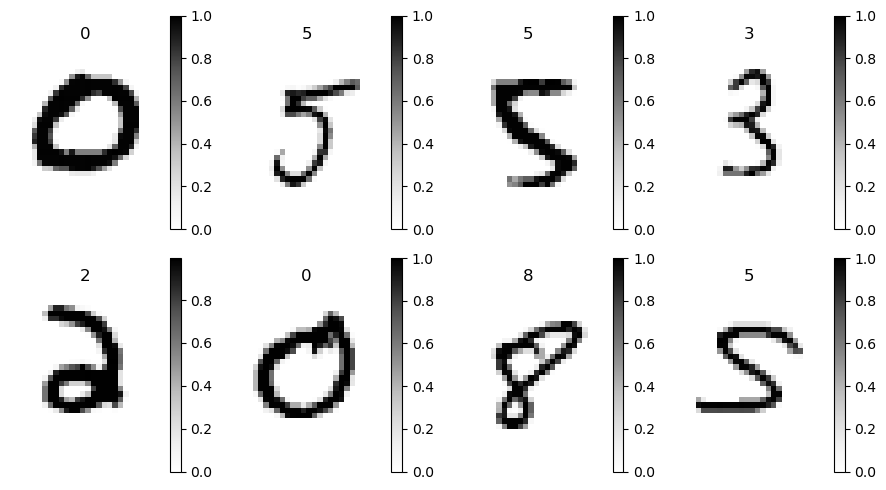

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-probability is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-probability evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## Gradient-based stochastic optimization
###  Derive gradient equations (20 points)

In this section, the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$, will be derived

We deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Try yourself now to complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not (answer will follow in next cell).




**Solution:**

For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} \\
&= 1 - \frac{1}{Z} \frac{\partial \sum_i \exp (\log (q_i))}{\partial \log(q_j)} \\
&= 1 - \frac{1}{Z} \exp (\log (q_j)) \\
&= 1 - \frac{q_j}{Z} 
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} \\
&= - \frac{q_j}{Z}
\end{align}


Given the equations for computing the gradients $\delta^q_j$ it is quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

Try again yourself: what is $\frac{\partial \log q_j}{\partial W_{ij}}$? If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

The answer:

$
\frac{\partial \log q_j}{\partial W_{ij}} = \frac{\partial }{\partial W_{ij}}(\textbf{w}^T_{j} \textbf{x} + b_{j}) = \frac{\partial }{\partial W_{ij}} (\sum_i W_{ij}x_i +b_j) = x_i
$

So 

$\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =  \mathbf{\delta}_j^q x_i $

### Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
def logreg_gradient(x, t, w, b):
    log_q = (w.T @ x.T).squeeze() + b # 10x1
    a = np.max(log_q) 
    log_Z = a + np.log(np.sum(np.exp(log_q - a))) # Log-sum-exp trick
    Z = np.exp(log_Z)
    dL_db = - np.exp(log_q) / Z
    dL_db[t] += 1
    dL_dw = x.T @ dL_db[np.newaxis]
    logp = log_q - log_Z
    logp = logp.reshape(1,-1) # 1x10
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [7]:
# DO NOT REMOVE THIS CELL!
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape



Test gradient on one point
Log Likelihood:	 -2.296585968775302

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [0.81827609 0.88881713 0.61018003 0.29979944 0.29979944 0.29979944]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [ 0.89939828 -0.09837106 -0.1015878  -0.10029629 -0.0983651  -0.10186094
 -0.10139518 -0.09875533 -0.09922724 -0.09953934]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 4.83431956881974e-07
Finite difference error grad_b: 1.982092717120638e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-4`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    lr = 1e-4
    logp_train = 0 
    
    for index in indices:
        log_p, grad_w, grad_b = logreg_gradient(x_train[index,:].reshape(1,-1), t_train[index], W, b)
        logp_train += log_p
        W += lr * grad_w
        b += lr * grad_b
    
    return logp_train, W, b

In [12]:
# DO NOT REMOVE THIS CELL!
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)


print (logp_train)


-11.514825363319948


#### Train

### Train (15 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

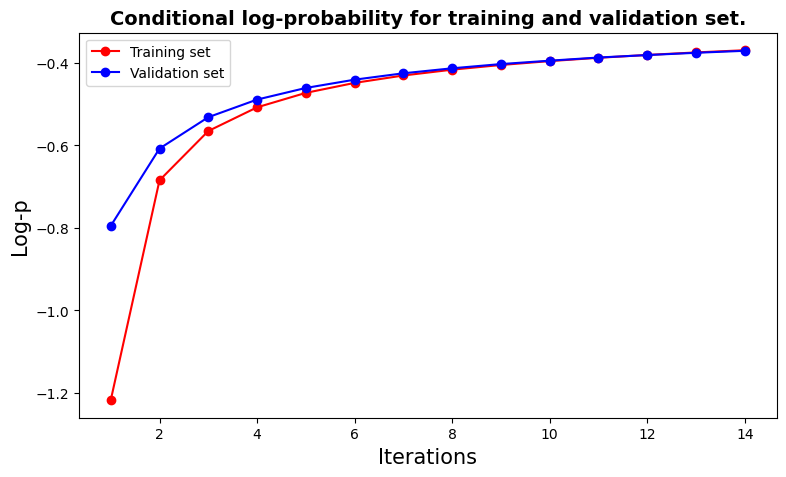

79.87725973129272


In [15]:
def test_sgd(x_train, t_train, x_valid, t_valid, w, b):    
    log_p_train_avgs = []
    log_p_valid_avgs = []
    x_train_len = x_train.shape[0]
    x_valid_len = x_valid.shape[0]
    step = 0
    log_p_train_prev = float('-inf') 
    while True:
        step += 1
#         print(step)
        
        w_old = w.copy()
        b_old = b.copy()
        log_p_train, w, b = sgd_iter(x_train, t_train, w, b)
#         print(numpy.linalg.norm(w - w_old))
        log_p_train_avgs.append(log_p_train / x_train_len)
        
        log_p_valid_sum = 0
        for x_sample, t_sample in zip(x_valid, t_valid):
            log_p_valid, _, _ = logreg_gradient(x_sample.reshape(1,-1), t_sample, w, b)
            log_p_valid_sum += log_p_valid
        log_p_valid_avgs.append(log_p_valid_sum / x_valid_len)
        
        # L2 norm (Euclidean norm) of the parameter difference as a convergence criterion 
        if numpy.linalg.norm(w - w_old) < 0.16: # and numpy.linalg.norm(b - b_old) < 0.16: # 0.15
            break
#         print(np.abs(log_p_train_avgs[-1] - log_p_train_prev))
#         if np.abs(log_p_train_avgs[-1] - log_p_train_prev) < 1e-6:
#             print(f"Converged after {step + 1} iterations.")
#             break
#         log_p_train_prev = log_p_train_avgs[-1]
        
    plt.plot(np.arange(len(log_p_train_avgs)) + 1, log_p_train_avgs, 'ro-', label='Training set')
    plt.plot(np.arange(len(log_p_valid_avgs)) + 1, log_p_valid_avgs, 'bo-', label='Validation set')
    title = "Conditional log-probability for training and validation set."
    plt.title(title,fontsize=14,fontweight="bold")
    plt.ylabel('Log-p',fontsize=15)
    plt.xlabel('Iterations',fontsize=15)
    plt.legend()
    plt.show()
    return w,b
    
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)

import time
start = time.time()
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)
end = time.time()
ellapsed_time = end - start

print (ellapsed_time)
assert np.allclose (ellapsed_time, 36.28032302856445, atol=50)

In [16]:
# DO NOT REMOVE THIS CELL!
# Hidden tests for efficiency


### Visualize weights
As a sanity check, Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


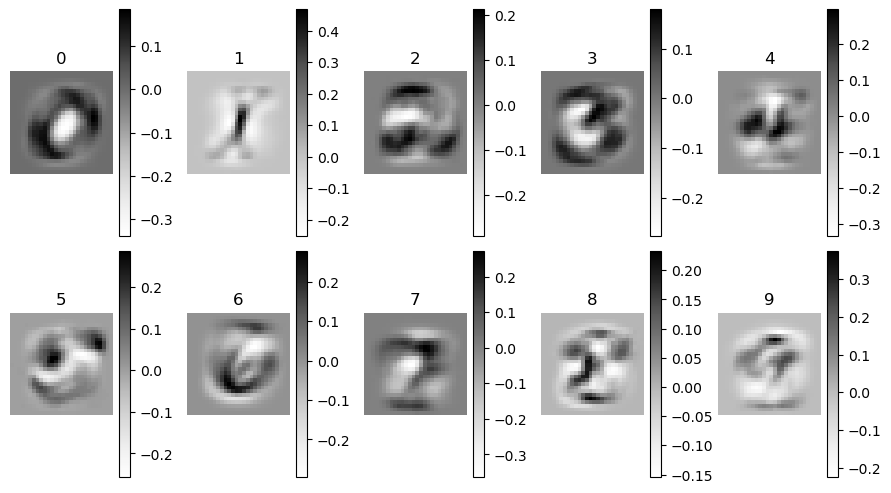

In [17]:
plot_digits(w.T, num_cols=5, targets=np.arange(10))

**Food for thoughL Think of reasons that these weights are minimizing your loss**
Note, you dont need to provide any answer in this question!

### Visualize the 8 hardest and 8 easiest digits
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


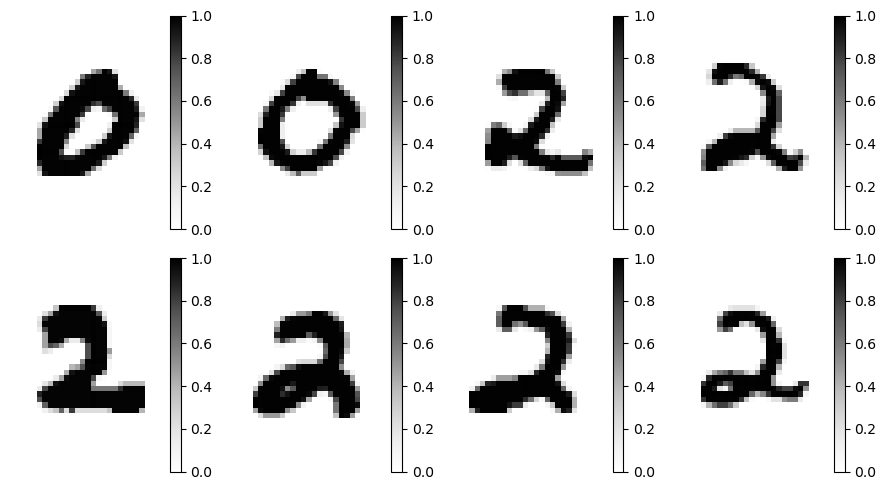

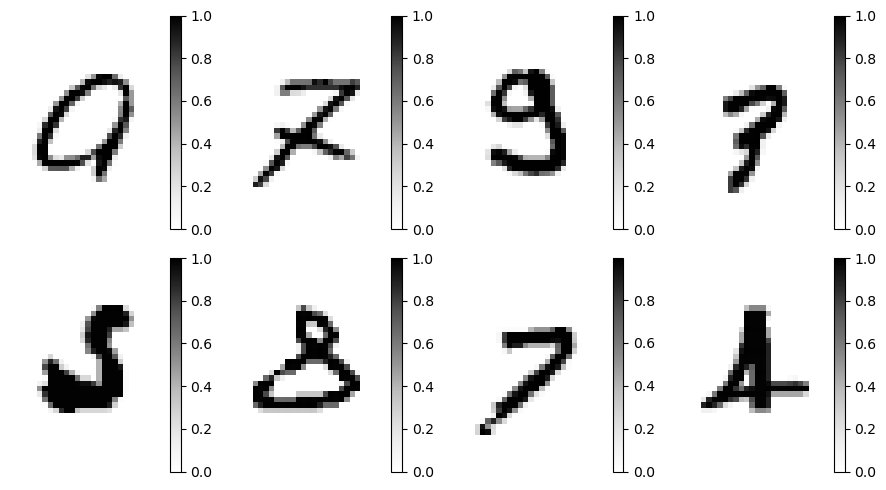

In [18]:
def logreg_logp(x, t, w, b):
    logq = np.dot(x, w) + b
    amax = np.max(logq, axis=-1, keepdims=True)
    logz = amax + np.log(np.sum(np.exp(logq - amax), axis=-1, keepdims=True))
    return logq[np.arange(len(t)), t] - logz.squeeze()

N = 8
logp_valid = logreg_logp(x_valid, t_valid, w, b)
easiest = np.argpartition(logp_valid, -N)[-N:]
hardest = np.argpartition(-logp_valid, -N)[-N:]

plot_digits(x_valid[easiest], num_cols=4)
plot_digits(x_valid[hardest], num_cols=4)

**Food for though: Ask yourself if these results make sense.**
You do not need to provide any answer on this question!

## Part 2. Principal Component Analysis (PCA) on MNIST (25 points)

### What is PCA?

Principal Component Analysis (PCA) is a statistical method aiming to transform the original variables into a new set of uncorrelated variables (principal components) that represent most of the variability in the dataset. The principal components are linear combinations of the original variables, defined as:

$$Y_i = a_{i1}X_1 + a_{i2}X_2 + \ldots + a_{ip}X_p $$

### Applying PCA to MNIST

1. **Data Preparation:** use the loaded MNIST dataset from the part 1 of the lab.
<br>
2. **Implementing PCA Function:** 
    - **Center the Data:** Subtract the mean of each feature, resulting in the mean-centered data $\bar{X}$:
    
    $$ \bar{X} = X - \mu_X $$
    
    where $\ \mu_X$  the mean of the data matrix $ X $ (NxD) calculated column-wise.
    
    - **Calculate Covariance Matrix:** Compute the covariance matrix $C$ of the mean-centered data $\bar{X}$. The covariance matrix is given by:
    
    $$ C = \frac{1}{N} \bar{X}^T \bar{X} $$
    
    - **Compute Eigenvalues and Eigenvectors:** Derive the eigenvalues and eigenvectors of the covariance matrix $C$. Each eigenvector represents a principal component, and the corresponding eigenvalue indicates the variance explained by that principal component.
<br>

3. **Choosing the Number of Components:** 
    - **Sort Eigenvalues:** Order the eigenvalues in descending order.
    
    $$ \lambda_1 \geq \lambda_2 \geq \ldots \geq \lambda_D $$
    
    - **Select Components:** Choose the smallest number $k$ such that the following holds:
    
    $$ \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{D} \lambda_i} \geq r $$
    
    where $r$ is the desired proportion of total variance to preserve.
<br>

4. **Data Transformation:** Use the original data $X$ and the chosen principal components to obtain the transformed data $Y$:
    
    $$ Y = X P_k $$
    
    where $P_k$ is the matrix with the first $k$ eigenvectors as columns.
<br>

5. **Reconstructing and Visualizing the Data:** Reconstruct the original data from the transformed data $Y$ by using the inverse transformation:
    
    $$ X_{\text{reconstructed}} = Y P_k^T $$

In [29]:
# Find eigenvecs/eigenvals of the centered covariance matrix. You can use np.linalg.eig to find the eigenvalues and eigenvectors.
# Args:
#     data (numpy.ndarray): The dataset to apply PCA on.
# Returns:
#     Tuple of:
#     - eigenvalues (numpy.ndarray): Eigenvalues representing variance explained by each component.
#     - eigenvectors (numpy.ndarray): Eigenvectors as directions of principal components.

def PCA(data):
    data = data - data.mean(0) # Center the Data
    cov_mat = np.dot(data.T, data) / len(data) # Calculate Covariance Matrix
    eig_values, eig_vectors = np.linalg.eig(cov_mat) # Compute Eigenvalues and Eigenvectors
       
    return (eig_values, eig_vectors)

In [30]:
# Select the optimal number of principal components based on a desired variance percentage. Don't forget to sort the eigenvalues/eigenvectors!
# Args:
#     eigenvalues (numpy.ndarray): Eigenvalues representing variance explained by each component.
#     eigenvectors (numpy.ndarray): Eigenvectors as directions of principal components.
#     percentage (float): Desired proportion of total variance to preserve.
# Returns:
#     selected_components (numpy.ndarray): Selected principal components that satisfy the explained variance threshold.

def select_components(eigenvalues, eigenvectors, percentage):
    e_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors_sorted = eigenvectors[:,e_indices] # Sort Eigenvalues
    
    variance_explained = 0
    proportion = 0
#     print(len(eigenvalues))
    for i, eigen_value in enumerate(eigenvalues):
#         print((eigen_value / sum(eigenvalues)))
        variance_explained += (eigen_value / sum(eigenvalues))
        proportion = i
        if variance_explained >= percentage: # The fist time it bev
            break
    print(proportion)
#     print(variance_explained)
    return eigenvectors_sorted[:, :proportion + 1] # Select Components

In [31]:
# Transform the data using selected principal components.
# Args:
#     data (numpy.ndarray): The data we wish to transform.
#     selected_components (numpy.ndarray): Selected principal components for transformation.
# Returns:
#     transformed_data (numpy.ndarray): Data transformed into a lower-dimensional space using PCA.

def transform_data(data, selected_components):
    transformed_data = np.dot(data, selected_components)
    return transformed_data

In [32]:
# Reconstruct the original data from transformed data using selected principal components.
# Args:
#     transformed_data (numpy.ndarray): Data transformed into a lower-dimensional space using PCA.
#     selected_components (numpy.ndarray): Selected principal components used for transformation.
# Returns:
#     reconstructed_data (numpy.ndarray): Data reconstructed from the lower-dimensional representation.

def reconstruct_data(transformed_data, selected_components):
    reconstructed_data = np.dot(transformed_data, selected_components.T)
    print(reconstructed_data.shape)
    return reconstructed_data

330
(50000, 784)
Original Images:


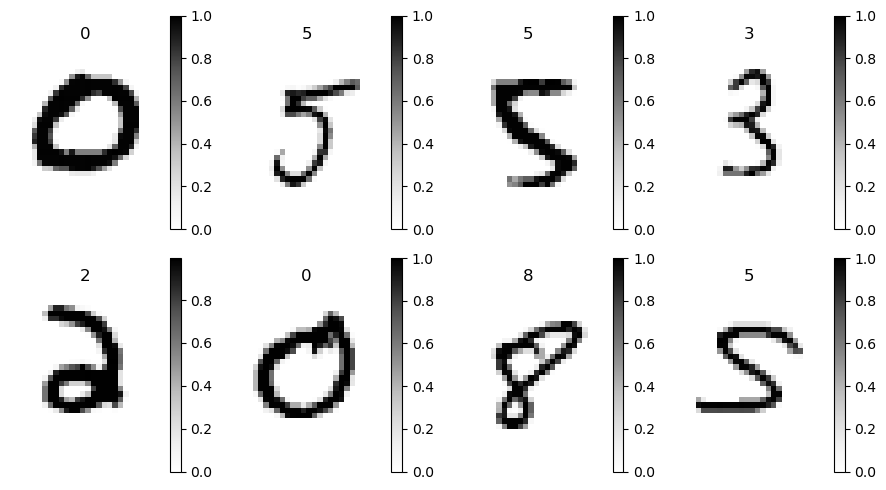

Reconstructed Images using Top 331 out of 784 Principal Components:


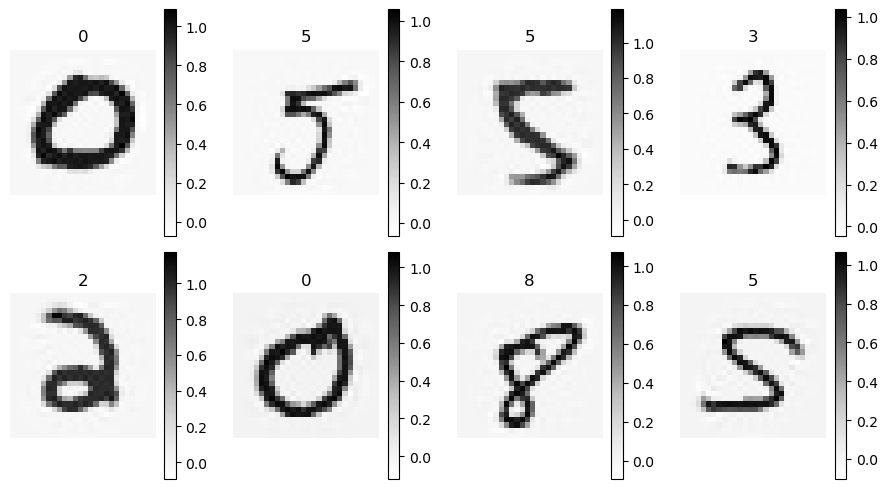

In [33]:
# Assuming data and targets are already loaded
# data: The original MNIST dataset
# targets: The corresponding labels
np.random.seed(123)

data = x_train
targets = t_train

# 1. Perform PCA to obtain eigenvalues and eigenvectors
eigenvalues, eigenvectors = PCA(data)


# 2. Select the top k principal components to preserve r of total variance
r = 0.99
selected_components = select_components(eigenvalues, eigenvectors, r)


# 3. Transform the data using the selected principal components
transformed_data = transform_data(data, selected_components)

# 4. Reconstruct the data back to the original space
reconstructed_data = reconstruct_data(transformed_data, selected_components)


# Plot the original images using the plotting function
print("Original Images:")
plot_digits(data[0:40000:5000], num_cols=4, targets=targets[0:40000:5000])

# Plot the reconstructed images
k = selected_components.shape[1]  # Number of top principal components retained
K = 784
print(f"Reconstructed Images using Top {k} out of {K} Principal Components:")
plot_digits(reconstructed_data[0:40000:5000], num_cols=4, targets=targets[0:40000:5000])